# Fifth Classifier

No age or image data, since those seem to be the explanatory variables the classifiers love the most.

## Imports

In [1]:
from itertools import chain
import html
import ujson as json
import multiprocessing as mp
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold

from helpers import all_scoring_metrics
from helpers import draw_rocs

%matplotlib inline
sns.set(context='talk')

num_folds = 10
eval_columns = ['f1',
                'accuracy',
                'true_negative_rate',
                'true_positive_rate',
                'roc_auc',
                'roc_fpr',
                'roc_tpr',
                'roc_thresholds']
price_cols = ['duration_in_mins',
              'price',
              'price_per_min']

In [2]:
df = pd.read_pickle('../../data/merged/data_to_use_by_phone_v4.pkl')
print(df.shape)
print(df['class'].value_counts())

(567, 343)
False    508
True      59
Name: class, dtype: int64


In [3]:
id_cols = {'class', 'phone'}
price_cols = {x for x in df.columns if x.find('price') > -1}
duration_cols = {x for x in df.columns if x.find('duration') > -1}
flag_cols = {x for x in df.columns if x.find('flag_') > -1}
ethnicity_cols = {x for x in df.columns if x.find('ethnicity_') > -1}
image_cols = {x for x in df.columns if x.find('image') > -1}
age_cols = {x for x in df.columns if x.find('age') > -1} | set(['flag_Juvenile'])
service_cols = {x for x in df.columns if x.find('incall') > -1 or x.find('outcall') > -1}
lattice_cols = flag_cols | ethnicity_cols | service_cols

In [4]:
etc = ExtraTreesClassifier(oob_score=True,
                           bootstrap=True,
                           random_state=2,
                           n_estimators=100,
                           n_jobs=-1,
                           class_weight="balanced")

rf = RandomForestClassifier(oob_score=True,
                            random_state=2,
                            n_estimators=100,
                            n_jobs=-1,
                            class_weight="balanced")

## Execution
Use both Random Forests and Extra Trees to classify the data using all columns

In [5]:
y_series = df['class']
X_df = df.loc[:, sorted(set(df.columns) - id_cols - age_cols - image_cols)]
print(y_series.shape)
print(X_df.shape)

(567,)
(567, 276)


### Extra Trees

In [6]:
etc_metrics = all_scoring_metrics(etc, X_df, y_series, StratifiedKFold(y_series, num_folds))

In [7]:
this_metrics = etc_metrics
print(this_metrics.roc_auc.mean())
this_metrics.loc[:, ['f1', 'accuracy', 'true_negative_rate', 'true_positive_rate', 'roc_auc']]

0.7837843137254902


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc
0,0.545455,0.912281,0.960784,0.500000,0.620915
1,0.307692,0.842105,0.901961,0.333333,0.720588
2,0.333333,0.789474,0.823529,0.500000,0.612745
3,0.187500,0.543860,0.549020,0.500000,0.565359
4,0.206897,0.596491,0.607843,0.500000,0.552288
5,0.500000,0.894737,0.941176,0.500000,0.910131
6,0.666667,0.929825,0.960784,0.666667,0.910131
7,0.545455,0.912281,0.960784,0.500000,0.965686
8,0.000000,0.892857,1.000000,0.000000,1.000000
9,0.833333,0.963636,0.960000,1.000000,0.980000


                                 feature     score
0         distinct_locations:nmlzd_count  0.058756
1                                  n_ads  0.051902
2                   location_tree_length  0.040538
3              missing_price:nmlzd_count  0.027643
4      missing_price_per_min:nmlzd_count  0.026105
5   missing_duration_in_mins:nmlzd_count  0.025088
6                     incall:nmlzd_count  0.024923
7                         flag_Traveling  0.024860
8         incall_and_outcall:nmlzd_count  0.024853
9                 flag_Foreign Providers  0.024046
10                     missing_price:std  0.022733
11                       ethnicity_Ebony  0.022116
12                   outcall:nmlzd_count  0.021651
13             missing_price_per_min:std  0.019420
14          missing_duration_in_mins:std  0.019157
15        cooccurring_phones:nmlzd_count  0.018321
16                       ethnicity_White  0.014537
17                   flag_Multiple Girls  0.013825
18                      ethnici

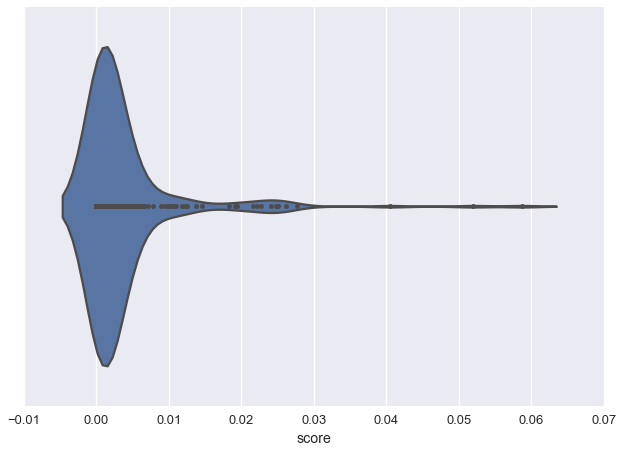

In [8]:
ranked_imptncs = this_metrics.loc[:,
                                  sorted(set(this_metrics.columns) - 
                                         set(eval_columns))].mean().sort_values(ascending=False).reset_index()
ranked_imptncs.columns = ['feature', 'score']
print(ranked_imptncs.head(20))
sns.violinplot(ranked_imptncs.score, inner='point')

In [9]:
print('Ethnicity: {}'.format(ranked_imptncs.loc[ranked_imptncs.feature.isin(ethnicity_cols), :].sum().score))
print('Age: {}'.format(ranked_imptncs.loc[ranked_imptncs.feature.isin(age_cols), :].sum().score))
print('Service: {}'.format(ranked_imptncs.loc[ranked_imptncs.feature.isin(service_cols), :].sum().score))
print('Lattice: {}'.format(ranked_imptncs.loc[ranked_imptncs.feature.isin(lattice_cols), :].sum().score))
print('Price: {}'.format(ranked_imptncs.loc[ranked_imptncs.feature.isin(price_cols), :].sum().score))
print('Duration: {}'.format(ranked_imptncs.loc[ranked_imptncs.feature.isin(duration_cols), :].sum().score))

Ethnicity: 0.3425183441667912
Age: 0.0
Service: 0.0714279576440048
Lattice: 0.5321037682544181
Price: 0.2028244552268678
Duration: 0.0955547833397314


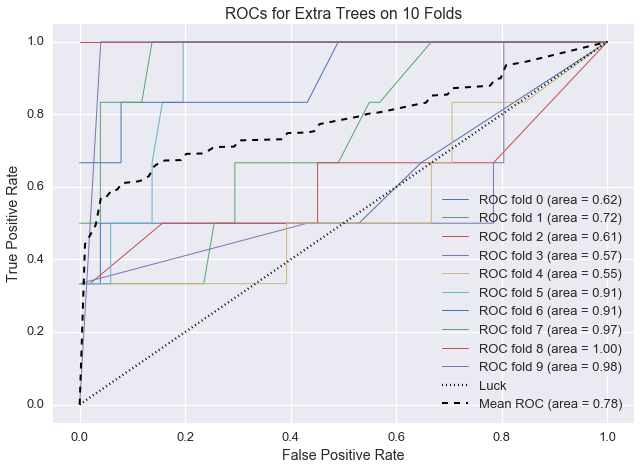

In [10]:
draw_rocs(this_metrics, 'Extra Trees')

### Random Forest

In [11]:
rf_metrics = all_scoring_metrics(rf, X_df, y_series, StratifiedKFold(y_series, num_folds))

In [12]:
this_metrics = rf_metrics
print(this_metrics.roc_auc.mean())
this_metrics.loc[:, ['f1', 'accuracy', 'true_negative_rate', 'true_positive_rate', 'roc_auc']]

0.7847647058823529


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc
0,0.400000,0.894737,0.960784,0.333333,0.676471
1,0.307692,0.842105,0.901961,0.333333,0.709150
2,0.333333,0.789474,0.823529,0.500000,0.611111
3,0.187500,0.543860,0.549020,0.500000,0.545752
4,0.142857,0.578947,0.607843,0.333333,0.557190
5,0.500000,0.894737,0.941176,0.500000,0.910131
6,0.666667,0.929825,0.960784,0.666667,0.916667
7,0.545455,0.912281,0.960784,0.500000,0.941176
8,0.000000,0.892857,1.000000,0.000000,1.000000
9,0.833333,0.963636,0.960000,1.000000,0.980000


                                 feature     score
0         distinct_locations:nmlzd_count  0.063694
1                                  n_ads  0.059888
2      missing_price_per_min:nmlzd_count  0.043547
3   missing_duration_in_mins:nmlzd_count  0.041373
4              missing_price:nmlzd_count  0.041313
5                   location_tree_length  0.036330
6                         flag_Traveling  0.027803
7                 flag_Foreign Providers  0.027300
8         incall_and_outcall:nmlzd_count  0.025340
9         cooccurring_phones:nmlzd_count  0.022617
10                       ethnicity_Ebony  0.020422
11                    incall:nmlzd_count  0.020369
12                     missing_price:std  0.018993
13                   outcall:nmlzd_count  0.017165
14                   flag_Multiple Girls  0.016759
15             missing_price_per_min:std  0.016332
16                             price:max  0.016325
17          missing_duration_in_mins:std  0.016056
18                             

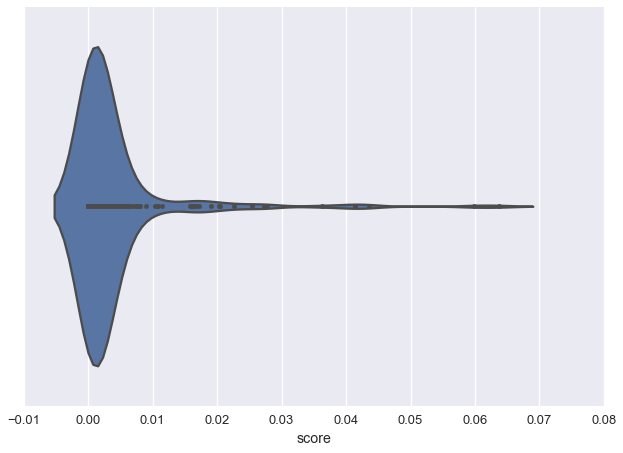

In [13]:
ranked_imptncs = this_metrics.loc[:,
                                  sorted(set(this_metrics.columns) - 
                                         set(eval_columns))].mean().sort_values(ascending=False).reset_index()
ranked_imptncs.columns = ['feature', 'score']
print(ranked_imptncs.head(20))
sns.violinplot(ranked_imptncs.score, inner='point')

In [14]:
print('Ethnicity: {}'.format(ranked_imptncs.loc[ranked_imptncs.feature.isin(ethnicity_cols), :].sum().score))
print('Age: {}'.format(ranked_imptncs.loc[ranked_imptncs.feature.isin(age_cols), :].sum().score))
print('Service: {}'.format(ranked_imptncs.loc[ranked_imptncs.feature.isin(service_cols), :].sum().score))

Ethnicity: 0.32792444848597296
Age: 0.0
Service: 0.06287399169822386


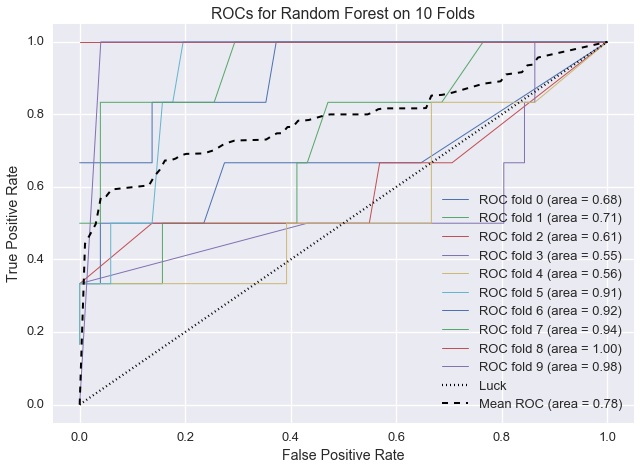

In [15]:
draw_rocs(this_metrics, 'Random Forest')